# Topic Modelling

This Notebook does some data exploration on the SQL database containing twitter data. The goal is to use topic modelling methods to look for common patterns and topics in the data.


### References
https://github.com/derekgreene/topic-model-tutorial

In [1]:
# Let us import some of the twitter data into a padas notebook

import sqlite3
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#conn = sqlite3.connect('location_based_database.db')
conn = sqlite3.connect('keyword_based_database.db')
#c = conn.cursor()
#c.execute('''SELECT * FROM tweet;''')

# Read into a Pandas Data Frame
df = pd.read_sql_query("SELECT * FROM tweet where tweet_text like '%BMW%' LIMIT 10000;",conn)
#df = pd.read_sql_query("SELECT * FROM tweet LIMIT 10000;",conn)

In [2]:
# Some simple Data exploration

print('Column Names: ', list(df.columns.values),"\n")

print('The size of the table: ', len(df),'\n')

# Show the First ten items in the database
print(df['tweet_text'][0:10])


# Let us make a histogram of the 

Column Names:  ['tweet_id_text', 'tweet_hashtag', 'tweet_text', 'created_at', 'geo_lat', 'geo_long', 'user_id_text'] 

The size of the table:  10000 

0    RT @BennyMabale: @nascar_lens I still think th...
1    RT @dimaagkoshot: Struggles as a star kid:\n1....
2    Your mcm drives again and is back on road with...
3    RT @ApjZwane: It's #VrrphaaTuesday  y'all\n#BM...
4    RT @icbc: Today’s #ThrowbackThursday features ...
5    2007 BMW 3-Series @ $7990Just arrived. Check i...
6    RT @NicoTeboho: For the love of BMW M8 ❤️❤️❤️ ...
7    RT @BMW: Setting the tempo for the next level....
8    RT @undercoverT1: 🏁Video Alert🏁 #CarsOnWednesd...
9    RT @BMW_SA: What does the future look like to ...
Name: tweet_text, dtype: object


In [3]:
# Sources: https://rustyonrampage.github.io/text-mining/2017/11/23/stemming-and-lemmatization-with-python-and-nltk.html


# Here we need to write a function that will clean up the tweet text:
# 1. Remove urls
# 2. Remove punctuation
# 3. 
import nltk
from textblob import TextBlob
from tqdm import tqdm
from collections import Counter 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import re

# Only needed once
#nltk.download('punkt')
#nltk.download('wordnet')

ps = PorterStemmer()
wnl = WordNetLemmatizer()

def get_pos( word ):
    '''
    Part-Of-Speech Tagger
    '''
    w_synsets = wordnet.synsets(word)
    
    
    # n-noun, v-verb, a-adjective, r-
    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

def clean_up_tweet(text):
    # Remove @ from the string
    s=re.sub(r'@[A-Za-z0-9]+','',text)    
    
    # Remove URLS
    s=re.sub('https?://[A-Za-z0-9./]+','',s)
    
    # Set to lower case
    s=s.lower()
    
    # Remove numbers
    s= re.sub(r'[0-9]+', '', s) 
    
    # Remove punctuation
    s = re.sub(r'[^\w\s]','',s)
    
    # Remove underscore
    s=s.replace("_", " ")
    
    # Remove RT from the tweet
    s=s.replace("rt", "")
    
    # Tokenize the words
    words = word_tokenize(s)
    
    # Lemmatize the words
    s_stem = ''
    for wi in words:
        #wi = ps.stem(wi)
        wi = wnl.lemmatize(wi,get_pos(wi))
        s_stem += ' ' + wi
    
    return s_stem

text = df['tweet_text'][6]

print("Example: ", text,'\n')
print("Cleaned up:",clean_up_tweet(text))


df['tweet_text'] = df['tweet_text'].apply(clean_up_tweet)

print('The size of the table: ', len(df),'\n')


# Remove duplicate tweets and reset the index
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)
df=df.reset_index(drop=True)
print('The size of the table: ', len(df),'\n')

Example:  RT @NicoTeboho: For the love of BMW M8 ❤️❤️❤️ https://t.co/8FMN5sd8Pz 

Cleaned up:  for the love of bmw m
The size of the table:  10000 

The size of the table:  4210 



In [4]:
import os.path
raw_documents = []
snippets = []

for k in range(0,len(df)):
    text = df['tweet_text'][k]
    raw_documents.append(text)
    snippets.append(text)
    #snippets.append( text[0:min(len(text),100)])

print("Read %d raw text documents" % len(raw_documents))

Read 4210 raw text documents


In [5]:
# Now we need to create the document term matrix
from sklearn.feature_extraction.text import CountVectorizer

# We will load in the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Stopword list has 355 entries
Created 4210 X 258 document-term matrix


In [6]:
from sklearn.externals import joblib

# We print out the number of features in the vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

# Save the vocabulary to a file
joblib.dump((A,terms,snippets), "articles-raw.pkl") 

Vocabulary has 258 distinct terms


['articles-raw.pkl']

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer


# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Created 4210 X 258 TF-IDF-normalized document-term matrix
Vocabulary has 258 distinct terms


In [8]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )
    
# Save these terms for later use    
joblib.dump((A,terms,snippets), "articles-tfidf.pkl") 

01. bmw (824.79)
02. car (184.95)
03. series (159.07)
04. drive (110.50)
05. get (99.46)
06. video (92.66)
07. sale (70.54)
08. buy (69.01)
09. look (63.20)
10. amp (55.85)
11. take (54.51)
12. bmws (54.42)
13. competition (54.18)
14. mercedes (51.24)
15. coupe (50.00)
16. driver (49.45)
17. see (48.11)
18. model (45.39)
19. time (44.94)
20. engine (43.39)


['articles-tfidf.pkl']

# Matrix Factorization

In [30]:
# We load the document term matrix
from sklearn import decomposition
from sklearn.externals import joblib

# Load in the Data
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

# create the model
k = 5 # The number of topics to generate
#model = decomposition.NMF( init="nndsvd", n_components=k ) 
model = decomposition.LatentDirichletAllocation(n_topics=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

Loaded 4210 X 258 document-term matrix


/home/javier/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(4210, 5)
0.785918037317
0.0456486811311
Topic:  1
Number of Tweets above the threshold:  1637
Topic:  2
Number of Tweets above the threshold:  1838
Topic:  3
Number of Tweets above the threshold:  1872
Topic:  4
Number of Tweets above the threshold:  1904
Topic:  5
Number of Tweets above the threshold:  1603


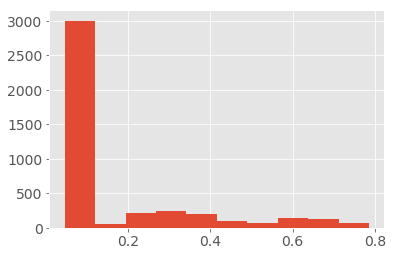

In [31]:
# The W[i][j] matrix, i represents the document, and j represents the association with a given topic
print(W.shape)

topic = 0
threshold = 0.1
print(max(W[:,topic]))
print(min(W[:,topic]))
plt.hist(W[:,topic])

N_topic_samples = []

for topic in range(0,k):
    above_threshold = len(W[W[:,topic]>=threshold,topic])
    print('=========================================================')
    N_topic_samples.append(above_threshold)
    print('Topic: ', topic+1)
    print( "Number of Tweets above the threshold: ", above_threshold )
    print('=========================================================')

# The H[i][j] matrix
#print(H.shape)

In [32]:

def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms


descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 12 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: bmw, fire, call, engine, car, ebay, back, love, need, win, uk, day
Topic 02: bmw, sale, series, mercedes, think, take, price, check, bmwm, mi, group, audi
Topic 03: bmw, get, video, drive, coupe, go, model, series, see, add, tesla, service
Topic 04: car, bmw, buy, bmws, driver, look, race, review, good, road, best, honda
Topic 05: bmw, fit, oem, rear, sa, mile, conveible, right, leave, pa, front, build


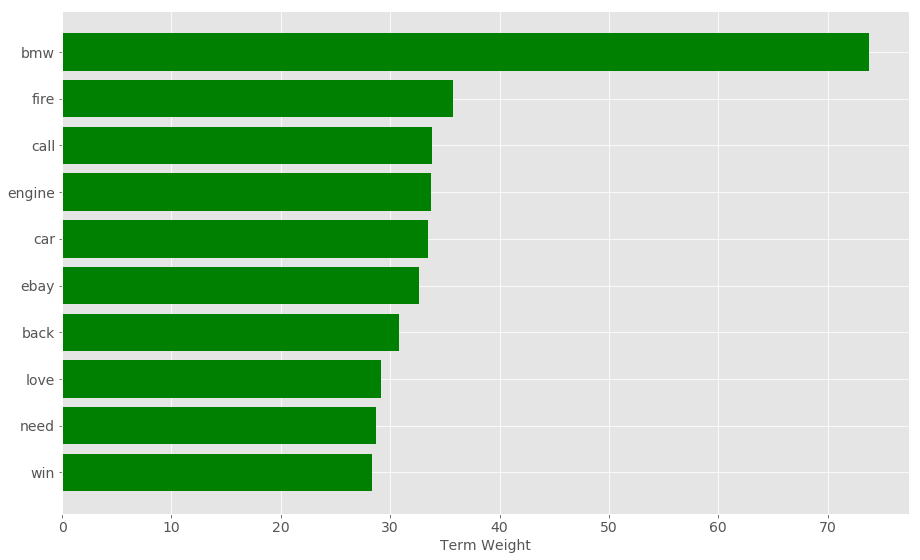


 Topic:  0
01.  bmw apologize over engine fire cause by hardware problem source ap seoul south korea ap bmw ag korean un 
02.  bmw korea offer free car rental for recall vehicle usa vacation travel 
03.  bmw apologize after engine fire in south korea prompt recall via 
04.  bmw apologize after engine fire in south korea prompt recall 
05.  bmw apologize over engine fire cause by hardware problem tampa bay time 
06.  bmw apologize over engine fire cause by hardware problem seattle time 
07.  ebay bmw series alvage repairable bmw i sell by state farm insurance car run and lot drive 
08.  bmw korea offer free car rental for recall vehicle 
09.  now available very low mileage bmw series i sedan with only k mile have spo pkg too offer at 
10.  s korea urge bmw owner to stop drive recall vehicle amid fire risk 
11.  bmw korea apologise over engine fire cause by hardware problem this aicle 
12.  bmw apologize over engine fire cause by hardware problem kiro seattle 
13.  bmw apologize over en

In [34]:
# Analysis using textblob
from textblob import TextBlob
import collections

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

topic = 0
dN_sentiment = 10 

def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()
    
    
plot_top_term_weights( terms, H, topic, 10 )    


# Let us look now at the most relevant posts for each topic

def get_top_snippets( all_snippets, W, topic_index, top ):
    
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, topic, 20 )

print('================================================')
print('\n Topic: ', topic)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s " % ( (i+1), snippet) )
print('================================================\n')    



In [35]:
def calculate(topic):
    
    for N_sentiment in range(5,N_topic_samples[topic]+1,dN_sentiment):
        sentiment_polarity_data= []
        sentiment_subjectivity_data= []
    
    # Get the top N_sentiment snippets  
    topic_snippets = get_top_snippets( snippets, W, topic, N_sentiment )
    
    # Calculate the sentiment of the top N_sentiment 
    for i, snippet in enumerate(topic_snippets):
        snippet_polarity_score =  TextBlob(snippet).sentiment.polarity # Polarity, [1]= subjectivity
        snippet_subjectivity_score = TextBlob(snippet).sentiment.subjectivity
        
        if(snippet_polarity_score>=0.5):
            sentiment_polarity_data.append(1.0)
        elif(snippet_polarity_score<=-0.5):
            sentiment_polarity_data.append(-1.0)
        else:
            sentiment_polarity_data.append(0.0)
            
    sentiment_polarity_data = np.asarray(sentiment_polarity_data)
    sentiment_subjectivity_data = np.asarray(sentiment_subjectivity_data)
    
    # Collect all results 
    pos = collections.Counter(sentiment_polarity_data)[1]/len(sentiment_polarity_data)*100.0
    neg = collections.Counter(sentiment_polarity_data)[-1]/len(sentiment_polarity_data)*100.0
    neut =  collections.Counter(sentiment_polarity_data)[0]/len(sentiment_polarity_data)*100.0
    N.append(N_sentiment)
    
    percent_negative.append(neg)
    percent_positive.append(pos)
    percent_neutral.append(neut)
    
    return N,percent_negative, percent_positive, percent_neutral

<Figure size 432x288 with 0 Axes>

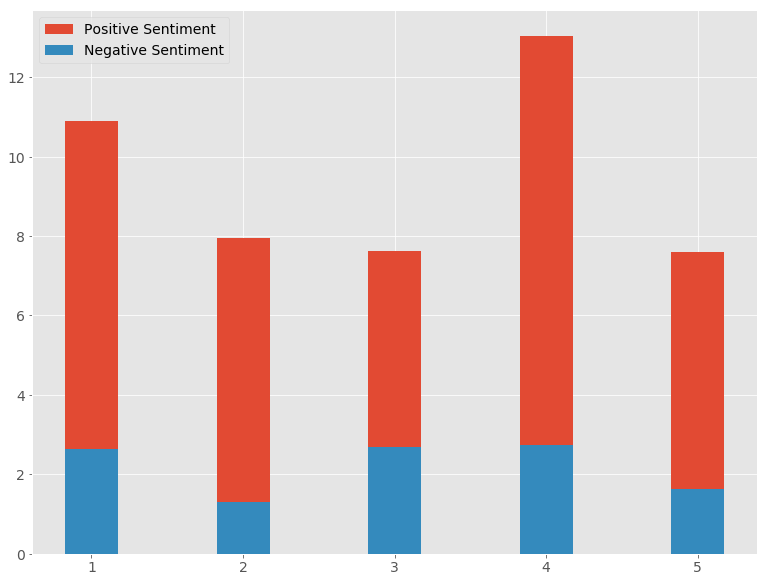

In [36]:
# Calculate the sentiments for all topics

topic_pos = np.zeros(k)
topic_neg = np.zeros(k)
topic_neutral = np.zeros(k)
topic_N = np.zeros(k)

for topic in range(k):
    N,percent_negative, percent_positive, percent_neutral = calculate(topic)
    topic_pos[topic] =  percent_positive[-1]
    topic_neg[topic] =  percent_negative[-1]
    topic_neutral[topic] = percent_neutral[-1]
    topic_N[-1] = N[-1]

width=0.35
x_axis_num = range(0,k)
x_axis_label = [str(i+1) for i in x_axis_num]
    
plt.clf()
plt.figure(figsize=(13,10))
plt.xticks(x_axis_num, x_axis_label)
plt.bar(x_axis_num, topic_pos, width,label="Positive Sentiment")
plt.bar(x_axis_num, topic_neg, width, label="Negative Sentiment")
plt.legend()
plt.show()